# Network Pruning

In this practical, we will be using PyTorch's `prune` module to  to implement different types of pruning mechanism on a CNN trained to detect land use from satellite images. We will be using [EuroSat (RGB)](https://github.com/phelber/eurosat) dataset for this task. This tutorial will work through the following steps - 

1. Load and explore EuroSAT (RGB) dataset containing RGB images. Note that there is a larger sized counterpart to EuroSAT dataset with multispectral (MS) images. For this tutorial, we will be using RGB images instead. Satellite MS images are handeled conveniently by [`torchgeo`](https://github.com/microsoft/torchgeo). EuroSAT(MS) is also available through `torchgeo.datasets`. 
2. Create and train a Deep CNN on EuroSAT (RGB). 
3. Explore various pruning techniques and the their pareto frontier, i,e., trade-off between accuracy and sparsity. Specifically, we will look at 
    - Random unstructured pruning with prune rate applied locally
    - L1 unstructured pruning with prune rate applied locally
    - L1 unstructured pruning with prune rate applied globally
    - L1 structured pruning

**WARNING**: 

1. This tutorial requires retraining the pruned model. Each step of retraining will be time consuming. To alleviate that, this tutorial comes with the trained pruned model in `./models/best_DeepCNN.ckpt`. A function `load_unpruned_model` loads the trained unpruned model. Thus, you can skip training of the unpruned model.

2. First 2 steps are standard to constructing any machine learning models. Therefore, we can skim through these steps. There are still some TODOs in case someone wants to run the tutorial from start to finish.

3. Jump over to **B. Network Pruning** to start learning how to prune models in PyTorch

4. If the kernel dies in between, the trained pruned model are saved in `./models` with their corresponding postfixes. Loading a pruned model in PyTorch requires some workarounds. Follow the code in `train` to learn more about details on how to do so. 

## A. Standard training 

### Basic imports

In [1]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
import math
import pathlib
import glob

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.utils.prune as prune #### NOTE: `prune` module need to be loaded like this only. https://github.com/pytorch/pytorch/issues/32483

from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from collections import defaultdict

# fix seed for reproducibility 
rng = np.random.RandomState(1)
torch.manual_seed(rng.randint(np.iinfo(int).max))

# it is a good practice to define `device` globally
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", device)
else:
    device = torch.device("cpu")
    print("No GPU -> using CPU:", device)

Using GPU: cuda


### Load Data

**Note:** There is no train, val, test split in this dataset, so we need to create it ourselves. 

In [2]:
torchvision.datasets.EuroSAT(root="./data", download=True)

Dataset EuroSAT
    Number of datapoints: 27000
    Root location: ./data

In [3]:
data = torchvision.datasets.EuroSAT(root='./data') 

### Explore Data

Look at the documentation of [torchvision.datasets.EuroSAT](https://pytorch.org/vision/stable/generated/torchvision.datasets.EuroSAT.html#torchvision.datasets.EuroSAT) to understand the data structure. 

In [4]:
print("What is the type of data?\n", type(data))
print("\nHow does an observation in data look like?\n", data[0])
print("Each obseervation is a tuple of (image, label)")
print("\nHow does an image in data look like?", data[0][0])
print("Each image is a 3x64x64 tensor")
print("\nHow many observations are there?\n", len(data))

What is the type of data?
 <class 'torchvision.datasets.eurosat.EuroSAT'>

How does an observation in data look like?
 (<PIL.Image.Image image mode=RGB size=64x64 at 0x7F53FD1B8FA0>, 0)
Each obseervation is a tuple of (image, label)

How does an image in data look like? <PIL.Image.Image image mode=RGB size=64x64 at 0x7F54A8501DF0>
Each image is a 3x64x64 tensor

How many observations are there?
 27000


We observe that the label is an index. In order to **understand what these labels mean**, we need to extract the class to index mapping. Can you investigate `dir(data)` to find the attrbiute that stores this map?

In [5]:
print("What is the class label to index mapping?")
data.class_to_idx

What is the class label to index mapping?


{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

Let's look at some of the images in each of these category. 

In [6]:
label_idx_map = defaultdict(list)
for idx in range(len(data)):
    label_idx_map[data[idx][1]].append(idx)

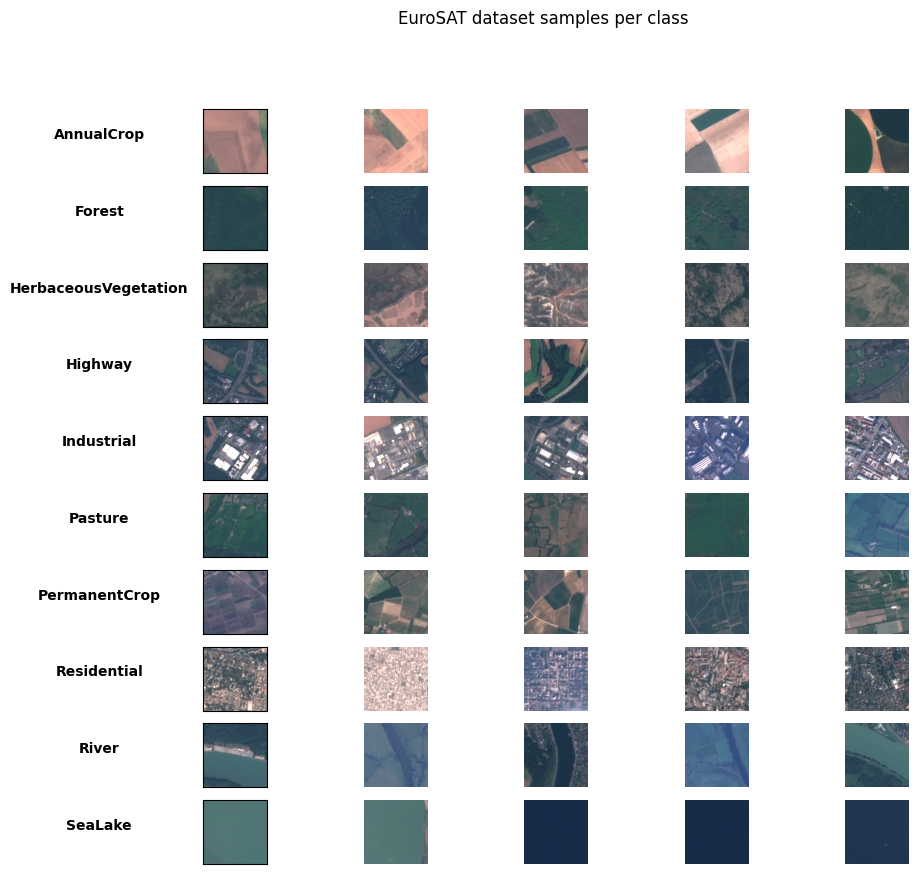

In [7]:
n_samples_per_class = 5
n_classes = len(data.class_to_idx)

fig, axs = plt.subplots(nrows=n_classes, ncols=n_samples_per_class , figsize=(10,10), dpi=100)

reverse_label_map = {idx:label for label, idx in data.class_to_idx.items()}
for row in range(n_classes):
    label = reverse_label_map[row]
    sample_img_idx = np.random.choice(label_idx_map[row], size=n_samples_per_class)
    
    axs[row][0].set_ylabel(label, fontweight='bold', rotation=0, labelpad=75)
    for j, img_idx in enumerate(sample_img_idx):
        ax = axs[row][j]
        ax.imshow(data[img_idx][0])
        ax.axis('off')
    
    axs[row][0].axis('on')
    axs[row][0].xaxis.set_ticks([])
    axs[row][0].yaxis.set_ticks([])
    
_ = fig.suptitle("EuroSAT dataset samples per class")

### Split data for training, validation and testing

Since we are interested in evaluating the generalization performance of the models, we will split the dataset into train and test datasets. 
We will use the train dataset to train the models and use the test datasets to evaluate the performance of these models. 
As per the standard practice, we will apply the normalization procedure as infered from the train dataset to the test dataset at the evaluation time. 

In [8]:
# split indices into train, val, and test indices
TRAIN_SPLIT=0.6
VAL_SPLIT=0.2
TEST_SPLIT=0.2
train_idxs, val_idxs, test_idxs = torch.utils.data.random_split(data, lengths=[int(TRAIN_SPLIT*len(data)), int(VAL_SPLIT*len(data)), int(TEST_SPLIT*len(data))], generator=torch.Generator().manual_seed(42))

We will convert PIL image to a numpy arrray using `np.asarray`, and compute the means and standard deviation across the RGB channels. 

In [9]:
X_train = torch.stack([torch.tensor(np.asarray(data[idx][0])) for idx in train_idxs.indices])

In [10]:
X_train.shape

torch.Size([16200, 64, 64, 3])

In [11]:
DATA_MEANS =  (X_train / 255.0).mean(axis=(0,1,2)) # to compute mean per channel, we will reduce the other dimensions
DATA_STD = (X_train / 255.0).std(axis=(0,1,2)) # to compute mean per channel, we will reduce the other dimensions

print(f"data means along three dimensions: {DATA_MEANS}")
print(f"data std along three dimensions: {DATA_STD}")


data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEANS, std=DATA_STD)
])

data means along three dimensions: tensor([0.3431, 0.3794, 0.4075])
data std along three dimensions: tensor([0.2023, 0.1370, 0.1157])


Now, we can apply `data_transforms` before the data is loaded. To do so, we need to create a `torch.utils.data.Dataset` class that can load individual observations and transform them before giving them to `torch.utils.data.DataLoader` that batches these observations together. 

Each of the custom `torch.utils.data.Dataset` classes, require the user to define `__getitem__` function to retrieve a single observation at `index` and `__len__` function to return the total number of observations.

In [12]:
class TransformedData(torch.utils.data.Dataset):
    def __init__(self, data, indices, transform):
        self.data = data
        self.subset_idxs = indices
        self.transform = transform 
    
    def __getitem__(self, index):
        x,y = self.data[self.subset_idxs[index]]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.subset_idxs)

In [13]:
val_data  = TransformedData(data, val_idxs.indices, data_transforms)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=256)

test_data = TransformedData(data, test_idxs.indices, data_transforms)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=256)

### Simple CNN model


In [14]:
class DeepCNN(nn.Module):
    def __init__(self, c_in, num_classes):
        super().__init__()
        self.input_args = [c_in, num_classes]
        
        # 
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(c_in, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),        
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),        
        )
        
        self.flatten = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1,1)), # kernel_size and stride are automatically inferred: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
            nn.Flatten(),
        )
        
        self.linear1 = nn.Sequential(
            nn.Linear(16, 256),
            nn.ReLU(),
        )
        
        self.out = nn.Sequential(
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv4(self.conv3(self.conv2(self.conv1(x))))
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.out(x)
        return x
                

We will write the standard functions to retrieve the attributes of the model, e.g., memory requirements, number of parameters, sparsity in the layers, and global sparsity. 

In [15]:
def mem_size(model):
    """
    Get model size in GB (as str: "N GB")
    """
    mem_params = sum(
        [param.nelement() * param.element_size() for param in model.parameters()]
    )
    mem_bufs = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
    mem = mem_params + mem_bufs
    return f"{mem / 1e9:.4f} GB"

def num_params(model):
    """
    Print number of parameters in model's named children
    and total
    """
    s = "Number of parameters (sparsity):\n"
    named_buffers = dict(model.named_buffers())
    n_params = 0
    for name, child in model.named_children():
        n = sum(p.numel() for p in child.parameters())
        if n == 0:
            continue

        nz = 0
        for child_name, p in child.named_parameters():
            if '_orig' in child_name:
                nz +=  torch.sum(named_buffers[f"{name}.{child_name.replace('_orig', '_mask')}"]).item()
            else:
                nz += torch.sum(p!=0).item()
#         nz = sum(torch.count_nonzero(p) for p in child.parameters())
        sparsity = (n-nz)/n
        s += f"  • {name:<15}: {n} \t {sparsity*100:2.3f}%\n"
        n_params += n
    s += f"{'total':<19}: {n_params}"

    return s


def compute_sparsity(model):
    named_buffers = dict(model.named_buffers())
    total_nnz, total_params = 0, 0
    for n, p in model.named_parameters():
        total_params += p.numel()
        
        if '_orig' in n:
            total_nnz += torch.sum(named_buffers[n.replace('_orig', '_mask')]).item()
        else:
            total_nnz += torch.sum(p!=0).item()

    return (total_params - total_nnz) / total_params


def pp_model_summary(model):
    print(num_params(model))
    print(f"{'Total memory':<18} : {mem_size(model)}")
    
    sparsity = compute_sparsity(model)
    print(f"{'Global sparsity':<18} : {100*sparsity: 2.3f}%")

Instantiate the model and print it's attributes.

In [16]:
model = DeepCNN(3, 10)
pp_model_summary(model)

Number of parameters (sparsity):
  • conv1          : 3840 	 3.333%
  • conv2          : 73920 	 0.087%
  • conv3          : 18528 	 0.173%
  • conv4          : 4656 	 0.344%
  • linear1        : 4352 	 0.000%
  • out            : 2570 	 0.000%
total              : 107866
Total memory       : 0.0004 GB
Global sparsity    :  0.222%


Define a standard training function that can be called on `model`. Rest of the arguments are intended for retraining the pruned model as mentioned in the docstring. Note that this setup is quite standard, and you might have followed it in the previous courses (e.g., Modern Network Architecture, Denoising Autoencoders, Attention is all you need, Deep Autoencoders)

In [17]:
def train(model, save_with_pruned_postfix="",n_epochs=100, print_every=1):
    """Trains the model. 
    
    Args:
        model (torch.nn.Module): model to be trained 
        save_with_pruned_postfix (str): The best model is saved with this as postfix
        n_epochs (int): maximum number of epochs to run
        print_every (int): print performance at every these number of epochs
    
    Returns:
        model (torch.nn.Module): best perforrming model 
        metrics (dict): metrics, e.g., losses, accuracy, etc.
    """
    model.to(device)
    
    pruning_postfix = f"_prune_{save_with_pruned_postfix}" if save_with_pruned_postfix else ""
    
    # fix seed for reproducibility 
    rng = np.random.RandomState(1)
    torch.manual_seed(rng.randint(np.iinfo(int).max))
    
    # create a model directory to store the best model
    model_dir = pathlib.Path("./models").resolve()
    if not model_dir.exists():
        model_dir.mkdir()
        
    epoch_size=200
    batch_size=64
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0
    no_improvement_count = 0
    for epoch in range(n_epochs):
        
        # training loss 
        epoch_indices = rng.choice(train_idxs.indices, epoch_size * batch_size, replace=True)
        train_dataloader = torch.utils.data.DataLoader(TransformedData(data, epoch_indices, data_transforms), batch_size=batch_size, num_workers=4)
        train_loss, train_acc = process(model, train_dataloader, optimizer)
        
        # validation loss 
        with torch.no_grad():
            val_loss, val_acc = process(model, val_dataloader, optimizer=None)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }, model_dir / f"best_{model.__class__.__name__}{pruning_postfix}.ckpt")
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            
            if no_improvement_count % 10 == 0:
                print("Early stopping...")
                break
        
        # logging 
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)  
        
        if epoch % print_every == 0:
            print(f"Epoch: {epoch}\t train loss:{train_loss: 0.5f}\t train acc: {100*train_acc:2.3f}%\t val_loss:{val_loss:0.5f}\t val_acc:{100*val_acc:2.3f}%")
        
    print(f"best val acc: {best_val_acc:0.3f}")

    # load the best model
    model = model.__class__(*model.input_args)
    if save_with_pruned_postfix:
        apply_mask_to_loaded_model(model) # a freshly initalized model doesn't 
    model.load_state_dict(torch.load(model_dir /  f"best_{model.__class__.__name__}{pruning_postfix}.ckpt")['model_state'])
    model = model.to(device) 
    
    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }
    return model, metrics


In [18]:
def process(model, dataloader, optimizer=None):
    n_samples = 0
    running_loss, running_acc = 0, 0
    for batch, labels in dataloader:
        # transfer to GPU if avaiable
        batch = batch.to(device)
        labels = labels.to(device)

        n_samples += batch.shape[0]
        
        # forward pass
        outputs = model(batch)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        preds = outputs.argmax(dim=1)
        
        # backward pass 
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()
        running_acc += (preds == labels).sum().float().item()
        
    return running_loss / n_samples, running_acc / n_samples
        
    

**Note:** This section can be skipped. The trained model will be provided in `./models` folder.

In [19]:
model, metrics = train(model)

/home/mila/g/guptapra/.conda/envs/dlc/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 0	 train loss: 0.03124	 train acc: 48.805%	 val_loss:0.00747	 val_acc:64.167%
Epoch: 1	 train loss: 0.02816	 train acc: 67.492%	 val_loss:0.00715	 val_acc:71.778%
Epoch: 2	 train loss: 0.02723	 train acc: 72.969%	 val_loss:0.00697	 val_acc:75.704%
Epoch: 3	 train loss: 0.02682	 train acc: 75.414%	 val_loss:0.00685	 val_acc:78.667%
Epoch: 4	 train loss: 0.02658	 train acc: 76.766%	 val_loss:0.00701	 val_acc:74.778%
Epoch: 5	 train loss: 0.02636	 train acc: 77.969%	 val_loss:0.00678	 val_acc:79.796%
Epoch: 6	 train loss: 0.02623	 train acc: 78.836%	 val_loss:0.00675	 val_acc:80.426%
Epoch: 7	 train loss: 0.02617	 train acc: 79.227%	 val_loss:0.00671	 val_acc:81.500%
Epoch: 8	 train loss: 0.02597	 train acc: 80.375%	 val_loss:0.00670	 val_acc:82.167%
Epoch: 9	 train loss: 0.02576	 train acc: 81.727%	 val_loss:0.00666	 val_acc:83.019%
Epoch: 10	 train loss: 0.02581	 train acc: 81.438%	 val_loss:0.00671	 val_acc:81.259%
Epoch: 11	 train loss: 0.02552	 train acc: 83.352%	 val_loss:0.0

In [20]:
# load the best model
def load_unpruned_model():
    model = DeepCNN(3, 10)
    model_dir = pathlib.Path("./models").resolve()
    model = model.__class__(*model.input_args)
    model.load_state_dict(torch.load(model_dir /  f"best_{model.__class__.__name__}.ckpt")['model_state'])
    model = model.to(device) 
    return model

def compute_test_accuracy(model):
    test_loss, test_acc = process(model, test_dataloader)
    return test_acc

model = load_unpruned_model()
unpruned_test_acc = compute_test_accuracy(model)

# 
print(f"Test accuracy of unpruned model:{unpruned_test_acc * 100:2.3f}%")
pp_model_summary(model)

Test accuracy of unpruned model:91.444%
Number of parameters (sparsity):
  • conv1          : 3840 	 0.000%
  • conv2          : 73920 	 0.000%
  • conv3          : 18528 	 0.000%
  • conv4          : 4656 	 0.000%
  • linear1        : 4352 	 0.000%
  • out            : 2570 	 0.000%
total              : 107866
Total memory       : 0.0004 GB
Global sparsity    :  0.000%


## B. Network Pruning


**How pruning is implemented PyTorch code?**

Recall that PyTorch stores its weights in `model.state_dict()`. PyTorch's pruning module changes the `model.state_dict()`. Specifically, it acts on the parameters defined by the `name` (e.g., `weight`, `bias`) attribute of the `module` (e.g., `nn.Linear` layer defined in `model`). During pruning, it computes a pruning mask, such that the weights to be pruned are assigned a value of 0. This mask is stored in `model.named_buffers()` with the key as `name_mask` (e.g., `weight_mask`, or `bias_mask`). At the same time, `model.state_dict()` now changes the corresponding key to `name_orig` (e.g., `weight_orig` or `bias_orig`), which stores the origin unpruned weights. At the run time, when the `model.forward` is called, the mask is applied to the unpruned weights. 

**What are the implications of such an implementation?**

1. **Size of the model**: Unless the `name_mask` parameters are removed, the size of the model will only grow. Thus, after pruning is complete, one can call `prune.remove` to thrrow away masks and store the weights to their pruned values. 

2. **Iterative pruning**: Every pruning iteration will create it's own mask. Thus, nothing special needs to be done. These masks are stored in a list as `module._forward_pre_hooks.values()`. 

3. **Saving a pruned model**: As explained above, pruned models carry masks with them. Thus, the pruned models need to be saved with their entire state if they are to be used later (e.g., after the pre-empted training). In our tutorial, we will only be saving `model.state_dict()`, however, in practice, you would want to save `model.named_buffers()` too. 

4. **Loading a pruned model**: Loading a pruned model follows a slightly different procedure as well. An unpruned model will not have any `name_orig` in their keys. However, the `state_dict` of the pruned model will contain such keys. Hence, the loading procedure will complain. Therefore, one needs to use `prune.identity` on these keys to tell PyTorch that these parameters were being pruned. 

**Telling PyTorch which layers to prune**

`prune` requires the user to specify which layers and what type parameters (e.g., `weight` or `biases`) are to be pruned. 


-----

In our tutorial, we will focus our pruning efforts only on the convolutional layers defined in `model.conv1`, `model.conv2`, `model.conv3`, and `model.conv4`. And we will focus only on `weight` parameters of these layers. 

**Note**: Each of these `conv` layers are defined as `nn.Sequential` which can be treated as a `list`. 

In [21]:
def get_weights_to_prune(model):
    """Returns the list of (module, name) in model to be pruned."""
    return [
        (model.conv1[0], 'weight'),
        (model.conv2[0], 'weight'),
        (model.conv3[0], 'weight'),
        (model.conv4[0], 'weight'),
    ]

def apply_mask_to_loaded_model(model):
    """
    Applies `prune.identity` to the freshly loaded model that was pruned earlier. 
    `prune.identity` tells `torch` which weights are in the process of being pruned, and hence need to be trated differrently.
    """
    m_weights_to_prune = get_weights_to_prune(model)
    for module, name in m_weights_to_prune:
        prune.identity(module=module, name=name)

### Random unstructured pruning

As a starting example, we will randomly prune weights in an unstructured fashion. To do so, we will use `prune.random_unstructured` functionality to define which modules and what parameters are to be pruned. Read the more [here](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html#pruning-a-module).

In [22]:
weights_to_prune = get_weights_to_prune(model)

In [23]:
PRUNE_RATE=0.3
for module, name in weights_to_prune:
    prune.random_unstructured(module=module, name=name, amount=PRUNE_RATE)

Let's look at the sparsity induced by above pruning and the resulting test accuracy. 

In [24]:
pruned_test_acc = compute_test_accuracy(model)
print(f"Pruned test acc: {100*pruned_test_acc: 2.3f}%")
pp_model_summary(model)

Pruned test acc:  44.593%
Number of parameters (sparsity):
  • conv1          : 3840 	 27.005%
  • conv2          : 73920 	 29.922%
  • conv3          : 18528 	 29.847%
  • conv4          : 4656 	 29.682%
  • linear1        : 4352 	 0.000%
  • out            : 2570 	 0.000%
total              : 107866
Total memory       : 0.0008 GB
Global sparsity    :  27.874%


Let's retrain the pruned mdoel and observe the effect on the test accuracy?

**Q.** Does the test accuracy increase or decrease? Can you reason why?

In [25]:
retrained_model, _ = train(model, save_with_pruned_postfix=f"random_unstructured_{PRUNE_RATE}", n_epochs=50, print_every=10)
pruned_test_acc = compute_test_accuracy(retrained_model)
print(f"Pruned test acc: {100*pruned_test_acc: 2.3f}%")
pp_model_summary(retrained_model)


Epoch: 0	 train loss: 0.02525	 train acc: 84.812%	 val_loss:0.00644	 val_acc:88.722%
Epoch: 10	 train loss: 0.02425	 train acc: 91.164%	 val_loss:0.00629	 val_acc:91.741%
Epoch: 20	 train loss: 0.02411	 train acc: 91.914%	 val_loss:0.00628	 val_acc:92.370%
Epoch: 30	 train loss: 0.02396	 train acc: 92.922%	 val_loss:0.00625	 val_acc:92.722%
Epoch: 40	 train loss: 0.02380	 train acc: 93.891%	 val_loss:0.00624	 val_acc:93.074%
best val acc: 0.946
Pruned test acc:  94.093%
Number of parameters (sparsity):
  • conv1          : 3840 	 27.005%
  • conv2          : 73920 	 29.922%
  • conv3          : 18528 	 29.847%
  • conv4          : 4656 	 29.682%
  • linear1        : 4352 	 0.000%
  • out            : 2570 	 0.000%
total              : 107866
Total memory       : 0.0008 GB
Global sparsity    :  27.874%


### Iterative finetuning

In practice, pruning is applied iterative. For this tutorial, we will apply pruning twice before jumping to other methods.

**Q.** How does the performance vary in this iteration? 

In [26]:
weights_to_prune = get_weights_to_prune(retrained_model)
for module, name in weights_to_prune:
    prune.random_unstructured(module=module, name=name, amount=PRUNE_RATE)


print("Iteration #2: \n")

# before finetuning
pruned_test_acc = compute_test_accuracy(retrained_model)
print(f"Pruned test acc: {100*pruned_test_acc: 2.3f}%")
pp_model_summary(retrained_model)

# after finetuning
retrained_model, _ = train(retrained_model, save_with_pruned_postfix=f"random_unstructured_{PRUNE_RATE}_#2", n_epochs=50, print_every=10)
pruned_test_acc = compute_test_accuracy(retrained_model)
print(f"Pruned test acc: {100*pruned_test_acc: 2.3f}%")
pp_model_summary(retrained_model)


Iteration #2: 

Pruned test acc:  38.981%
Number of parameters (sparsity):
  • conv1          : 3840 	 45.911%
  • conv2          : 73920 	 50.867%
  • conv3          : 18528 	 50.739%
  • conv4          : 4656 	 50.473%
  • linear1        : 4352 	 0.000%
  • out            : 2570 	 0.000%
total              : 107866
Total memory       : 0.0008 GB
Global sparsity    :  47.387%
Epoch: 0	 train loss: 0.02563	 train acc: 82.219%	 val_loss:0.00638	 val_acc:89.741%
Epoch: 10	 train loss: 0.02391	 train acc: 93.219%	 val_loss:0.00621	 val_acc:93.648%
Epoch: 20	 train loss: 0.02379	 train acc: 93.938%	 val_loss:0.00622	 val_acc:93.500%
Epoch: 30	 train loss: 0.02378	 train acc: 94.000%	 val_loss:0.00622	 val_acc:93.574%
Early stopping...
best val acc: 0.946
Pruned test acc:  94.056%
Number of parameters (sparsity):
  • conv1          : 3840 	 45.911%
  • conv2          : 73920 	 50.867%
  • conv3          : 18528 	 50.739%
  • conv4          : 4656 	 50.473%
  • linear1        : 4352 	 0.000%

### L1 Unstructured (local)

To prune the weights with lowest magnitude (i.e., L1-norm), use the `prune.11_unstructured`. Read more at the [documentation here](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.l1_unstructured.html). 

### L1 Structured (local)

`prune.ln_structured` lets the user define the dimension along which norm is to be computed. Thus, if the CNN weights are of shape `[3, 32, 32]` and we want to eliminate some filters, i.e., channels in dimension 0, the function expects an argument `dim` corresponding to that. [Read more about the function here](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.ln_structured.html).

### L1 Unstructured (global)

Finally, `prune.global_unstructured` can apply the prune rate globally across the specified modules. [Read its documentation here](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.global_unstructured.html).

Now, complete the functions below with their corresponding arguments. 

In [27]:
model = load_unpruned_model()
unpruned_test_acc = compute_test_accuracy(model)

PRUNE_RATES = [0.3, 0.5, 0.7]
N_RETRAINING_EPOCHS = 15
PRINT_EVERY=N_RETRAINING_EPOCHS//3

# random unstructured pruning 
print("\nRandom Unstructured (local)\n")
random_unstructured_performance = []
for prune_rate in PRUNE_RATES:
    model = load_unpruned_model()
    weights_to_prune = get_weights_to_prune(model)
    for module, name in weights_to_prune:
        prune.random_unstructured(module=module, name=name, amount=prune_rate)
    
    retrained_model, _ = train(model, save_with_pruned_postfix=f"random_unstructured_{prune_rate}", n_epochs=N_RETRAINING_EPOCHS, print_every=PRINT_EVERY)
    sparsity = compute_sparsity(retrained_model)
    test_acc = compute_test_accuracy(retrained_model)
    
    random_unstructured_performance.append((sparsity, test_acc))


# l1 unstructured pruning (local)
print("\nL1 Unstructured (local)\n")
l1_unstructured_performance = []
for prune_rate in PRUNE_RATES:
    model = load_unpruned_model()
    weights_to_prune = get_weights_to_prune(model)
    for module, name in weights_to_prune:
        prune.l1_unstructured(module=module, name=name, amount=prune_rate)
    
    retrained_model, _ = train(model, save_with_pruned_postfix=f"l1_unstructured_{prune_rate}", n_epochs=N_RETRAINING_EPOCHS, print_every=PRINT_EVERY)
    sparsity = compute_sparsity(retrained_model)
    test_acc = compute_test_accuracy(retrained_model)
    
    l1_unstructured_performance.append((sparsity, test_acc))

# l1 unstructured pruning (global)
print("\nL1 Unstructured (global)\n")
l1_unstructured_global_performance = []
for prune_rate in PRUNE_RATES:
    model = load_unpruned_model()
    weights_to_prune = get_weights_to_prune(model)
    prune.global_unstructured(weights_to_prune, pruning_method=prune.L1Unstructured, amount=prune_rate)
    
    retrained_model, _ = train(model, save_with_pruned_postfix=f"l1_unstructured_global_{prune_rate}", n_epochs=N_RETRAINING_EPOCHS, print_every=PRINT_EVERY)
    sparsity = compute_sparsity(retrained_model)
    test_acc = compute_test_accuracy(retrained_model)
    
    l1_unstructured_global_performance.append((sparsity, test_acc))


# l1 structured pruning (local) 
print("\nL1 structured\n")
l1_structured_performance = []
for prune_rate in PRUNE_RATES:
    model = load_unpruned_model()
    weights_to_prune = get_weights_to_prune(model)
    for module, name in weights_to_prune:
        prune.ln_structured(module=module, name=name, amount=prune_rate, n=1, dim=0)

    
    retrained_model, _ = train(model, save_with_pruned_postfix=f"l1_structured_{prune_rate}", n_epochs=N_RETRAINING_EPOCHS, print_every=PRINT_EVERY)
    sparsity = compute_sparsity(retrained_model)
    test_acc = compute_test_accuracy(retrained_model)
    
    l1_structured_performance.append((sparsity, test_acc))





Random Unstructured (local)

Epoch: 0	 train loss: 0.02525	 train acc: 84.812%	 val_loss:0.00644	 val_acc:88.722%
Epoch: 5	 train loss: 0.02443	 train acc: 89.875%	 val_loss:0.00647	 val_acc:88.148%
Epoch: 10	 train loss: 0.02425	 train acc: 91.164%	 val_loss:0.00629	 val_acc:91.741%
best val acc: 0.928
Epoch: 0	 train loss: 0.02600	 train acc: 79.789%	 val_loss:0.00649	 val_acc:86.907%
Epoch: 5	 train loss: 0.02443	 train acc: 90.023%	 val_loss:0.00638	 val_acc:90.352%
Epoch: 10	 train loss: 0.02443	 train acc: 90.086%	 val_loss:0.00640	 val_acc:89.333%
best val acc: 0.919
Epoch: 0	 train loss: 0.02764	 train acc: 69.250%	 val_loss:0.00689	 val_acc:77.056%
Epoch: 5	 train loss: 0.02477	 train acc: 87.664%	 val_loss:0.00644	 val_acc:88.704%
Epoch: 10	 train loss: 0.02455	 train acc: 89.195%	 val_loss:0.00637	 val_acc:90.185%
best val acc: 0.912

L1 Unstructured (local)

Epoch: 0	 train loss: 0.02442	 train acc: 90.031%	 val_loss:0.00637	 val_acc:90.000%
Epoch: 5	 train loss: 0.02414	 

Finally, **plot** the trade-off between sparsity and accuracy.

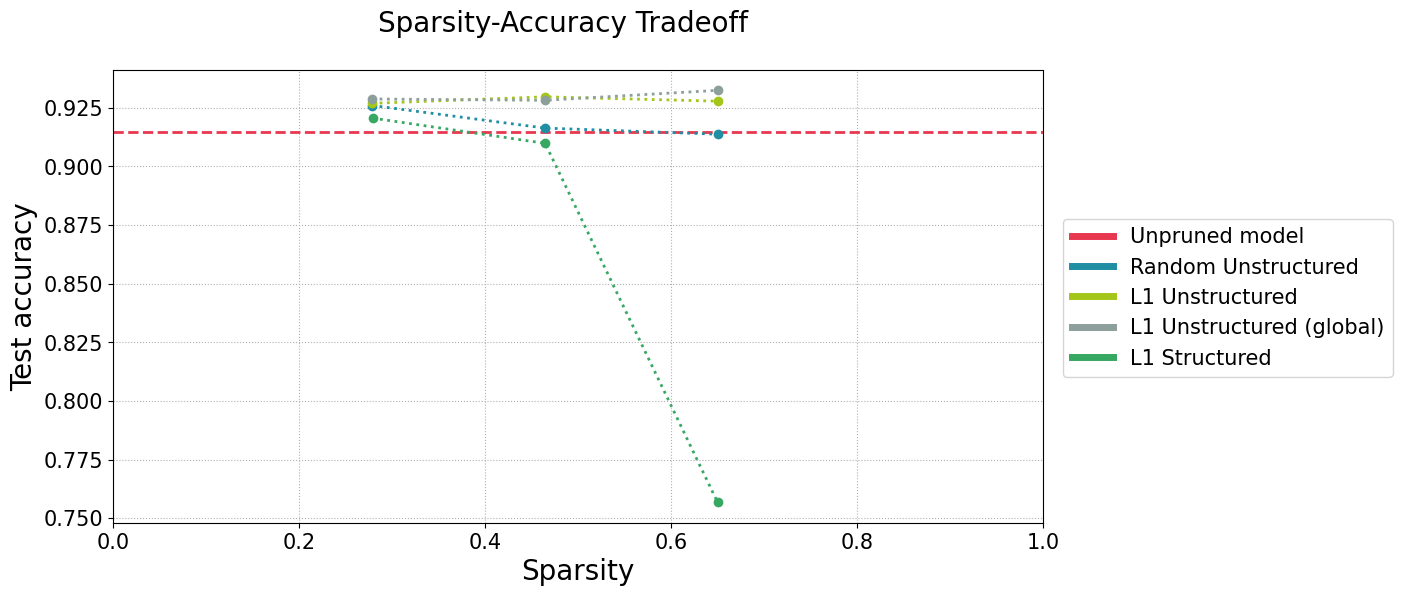

In [28]:
# plot various performances

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(12,6), dpi=100)

# unpruned model 
axs.hlines(y=unpruned_test_acc, xmin=0, xmax=1, linestyles="--", colors='#E8384F', linewidth=2)

# random unstructured
x,y = zip(*random_unstructured_performance)
axs.plot(x, y, color="#208EA3", linestyle=":", marker="o", label="random unstructured", linewidth=2)

# l1 unstructured (local)
x,y = zip(*l1_unstructured_performance)
axs.plot(x, y, color="#A4C61A", linestyle=":", marker="o", label="l1 unstructured", linewidth=2)


# l1 unstructured (global)
x,y = zip(*l1_unstructured_global_performance)
axs.plot(x, y, color="#8D9F9B", linestyle=":", marker="o", label="l1 unstructured (global)", linewidth=2)


# l1 structured
x,y = zip(*l1_structured_performance)
axs.plot(x, y, color="#37A862", linestyle=":", marker="o", label="l1 structured", linewidth=2)

axs.set_ylabel("Test accuracy", fontsize=20)
axs.set_xlabel("Sparsity", fontsize=20)

# tick size
for tick in axs.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)

for tick in axs.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

axs.set_xlim(0,1)
axs.grid(True, linestyle=':')

# legend

legend = []
legend.append(Line2D([0,1], [1,0], color="#E8384F", label="Unpruned model", linewidth=5))
legend.append(Line2D([0,1], [1,0], color="#208EA3", label="Random Unstructured", linewidth=5))
legend.append(Line2D([0,1], [1,0], color="#A4C61A", label="L1 Unstructured", linewidth=5))
legend.append(Line2D([0,1], [1,0], color="#8D9F9B", label="L1 Unstructured (global)", linewidth=5))
legend.append(Line2D([0,1], [1,0], color="#37A862", label="L1 Structured", linewidth=5))
lgd = fig.legend(handles=legend, ncol=1, fontsize=15, loc="center right", fancybox=True, bbox_to_anchor=(1.0, 0.5, 0.2, 0))


_ = fig.suptitle("Sparsity-Accuracy Tradeoff", fontsize=20)


### Saving a pruned model 

To reduce the size of the pruned model, we remove the masks in `model.state_dict()`. This is convenientyl done by `prune.remove(module, name)`. Read more about it [here](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html#remove-pruning-re-parametrization).

### Defining a custom pruning method 

Applying a pruning method requires defining computing mask. This can be done through a custom class. See [here](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html#extending-torch-nn-utils-prune-with-custom-pruning-functions) to learn how to extend pruning method. 